In [1]:
!pip3 install scikit-surprise
! pip install papermill
! pip install recommenders[examples,gpu]
!pip install cleanipynb

     |████████████████████████████████| 11.8 MB 2.0 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619416 sha256=27b4200ba69c4d9e2dad239ebb2bcf476057c2bc246c48c050ec1164be037bd8
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
     |████████████████████████████████| 156 kB 3.1 MB/s 
     |████████████████████████████████| 129 kB 10.7 MB/s 
     |████████████████████████████████| 843 kB 11.4 MB/s 
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


     |████████████████████████████████| 314 kB 2.0 MB/s 
     |████████████████████████████████| 3.4 MB 34.7 MB/s 
     |████████████████████████████████| 1.5 MB 51.1 MB/s 
     |████████████████████████████████| 22.3 MB 58.5 MB/s 
     |████████████████████████████████| 310 kB 50.1 MB/s 
     |████████████████████████████████| 61 kB 7.3 MB/s 
     |████████████████████████████████| 636 kB 65.7 MB/s 
     |████████████████████████████████| 59 kB 5.8 MB/s 
     |████████████████████████████████| 12.4 MB 22.7 MB/s 
     |████████████████████████████████| 93 kB 1.8 MB/s 
     |████████████████████████████████| 411.0 MB 22 kB/s 
     |████████████████████████████████| 748.9 MB 515 bytes/s 
     |████████████████████████████████| 766 kB 37.3 MB/s 
     |████████████████████████████████| 123 kB 39.6 MB/s 
     |████████████████████████████████| 85 kB 3.7 MB/s 
     |████████████████████████████████| 40 kB 5.0 MB/s 
     |████████████████████████████████| 296 kB 36.7 MB/s 
     |█████████████

     |████████████████████████████████| 297 kB 3.0 MB/s 
     |████████████████████████████████| 69 kB 6.5 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 83 kB 2.2 MB/s 
  Created wheel for autoflake: filename=autoflake-1.4-py3-none-any.whl size=14715 sha256=ac4977befcdeb36a17d48a1c6eb0059fe92676175395357ccb2b7c1dbf2df902
  Stored in directory: /root/.cache/pip/wheels/b7/00/d8/571fb2a3680ae44e45915355665b54b778a9c7cbce6f96ecde
Successfully built autoflake


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import surprise
from surprise import Reader
from surprise import Dataset
from surprise import KNNBaseline
from surprise import accuracy
from collections import defaultdict
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)
from recommenders.models.surprise.surprise_utils import predict, compute_ranking_predictions
from recommenders.datasets.python_splitters import python_random_split
from recommenders.utils.timer import Timer
import json


In [5]:
df = pd.DataFrame()
df[["userID", "itemID", "rating"]] = pd.read_json("/content/AMAZON_FASHION_5.71.268 (1).json")[["userID", "itemID", "rating"]]
df.head()

,userID,itemID,rating
10,A3HX4X3TIABWOV,B000KPIHQ4,2
17,A3HX4X3TIABWOV,B000V0IBDM,2
24,A3QY3THQ42WSCQ,B000YFSR5G,1
25,AGZ5OOZVDO194,B000YFSR5G,5
26,A3GJ3DJU1RXOHN,B000YFSR4W,4


In [6]:
df.shape

(3010, 3)

In [7]:
df['rating'].value_counts()

5    2072
4     443
3     310
1     109
2      76
Name: rating, dtype: int64

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
sparsity = lambda dataf: dataf.isna().sum().sum() / (dataf.shape[0] * dataf.shape[1])

In [10]:
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

density = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d ratings from %d users on %d products (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], (1 - density) * 100))


After filtering, there are 3010 ratings from 388 users on 27 products (sparsity: 71.268%)


In [11]:
df.rating.value_counts()

5    2072
4     443
3     310
1     109
2      76
Name: rating, dtype: int64

In [12]:
df.shape

(3010, 3)

# Initial Run of the Algorithm

In [13]:
train, test = python_random_split(df, 0.8)

In [14]:
reader = Reader(rating_scale=(1,5),)
train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

In [15]:
test_set= Dataset.load_from_df(test[['userID', 'itemID', 'rating']], reader)

In [16]:
param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
gs.fit(train_set)



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

In [17]:
sim_options = {'name': 'pearson_baseline',
               'user_based': False}
knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
knn.fit(train_set.build_full_trainset())

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [18]:
predictions = predict(knn, test, usercol='userID', itemcol='itemID')
predictions.head()

,userID,itemID,prediction
0,ASOSP4VAUDB7I,B014IBJKNO,4.006458
1,A140XVPLRQYKYY,B0058YEJ5K,4.003481
2,ATSUXY7ASCGPY,B014IBJKNO,4.004878
3,A1S4O68F0UG4GA,B001IKJOLW,4.993395
4,A2CP5A30XO5JUO,B009MA34NY,5.000000


In [19]:
with Timer() as test_time:
    all_predictions = compute_ranking_predictions(knn, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
print("Took {} seconds for prediction.".format(test_time.interval))

Took 0.2123872150000352 seconds for prediction.


In [20]:
eval_rmse = rmse(test, predictions)
eval_mae = mae(test, predictions)
eval_rsquared = rsquared(test, predictions)
eval_exp_var = exp_var(test, predictions)

k = 10
eval_map = map_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)


print("RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae,
      "rsquared:\t%f" % eval_rsquared,
      "exp var:\t%f" % eval_exp_var, sep='\n')

print('----')

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

RMSE:		0.139930
MAE:		0.020032
rsquared:	0.981423
exp var:	0.981431
----
MAP:	0.550510
NDCG:	0.590767
Precision@K:	0.127273
Recall@K:	0.669801


In [21]:
newTable = PrettyTable(["Algorithm", "Sparsity", "Precision@k", "Recall@k", "NDCG@k", "MAP@k"]) 
sparse=0.70
newTable.add_row(["KNN_Baseline", sparse, eval_precision , eval_recall, eval_ndcg, eval_map])   
print(newTable)

+--------------+----------+--------------------+--------------------+--------------------+--------------------+
|  Algorithm   | Sparsity |    Precision@k     |      Recall@k      |       NDCG@k       |       MAP@k        |
+--------------+----------+--------------------+--------------------+--------------------+--------------------+
| KNN_Baseline |   0.7    | 0.1272727272727273 | 0.6698014629049113 | 0.5907667786999632 | 0.5505102751654476 |
+--------------+----------+--------------------+--------------------+--------------------+--------------------+


# Model Pipeline Functions

In [22]:
def _print(message, verbose):
    if verbose:
        print(message)
    

def load_dataset(fp):
    df = pd.DataFrame()
    try:
        df[["userID", "itemID", "rating"]] = pd.read_json(fp)[["userID", "itemID", "rating"]]
    except:
        df = pd.read_json(fp)
    return df


def filter_to_sparsity(df, sparsity_percentage, verbose = False):
    # Obtain both usercount and itemcount after filtering
    usercount = df[['userID']].groupby('userID', as_index = False).size()
    itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))

    _print(f"After filtering, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    
    drop_item_ratings = int(-((1-sparsity_percentage) * (usercount.shape[0] * itemcount.shape[0]) - df.shape[0]))
    print(f"To obtain a sparsity of {sparsity_percentage * 100}% we need to drop {drop_item_ratings} ratings")
    drop_indices = np.random.choice(df.index, size=drop_item_ratings)
    df.drop(drop_indices, inplace=True)

    sparsity = 1 - (df.shape[0] / (usercount.shape[0] * itemcount.shape[0]))
    _print(f"After dropping cells, there are {df.shape[0]} ratings from {usercount.shape[0]} users on {itemcount.shape[0]}" + 
           f" products (sparsity: {sparsity * 100:.3f})", verbose)
    return df


In [23]:
def data_loading_pipeline(fp, sparsity_percentage=None, with_writing=False):
    """
    fp: str = Filepointer to desired user-item-ratings json.
    sparsity_percentage: float = value between 0-1.
    """
    df = load_dataset(fp)
    #df = filter_on_minimal_ratings(df)
    df = filter_to_sparsity(df, sparsity_percentage)
    
    return df




In [24]:
results = {0.75: [[], [], [], [], [], [], [], []],
           0.80: [[], [], [], [], [], [], [], []],
           0.85: [[], [], [], [], [], [], [], []],
           0.90: [[], [], [], [], [], [], [], []], 
           0.95: [[], [], [], [], [], [], [], []]}
spt = [0.75, 0.8 , 0.85, 0.9 , 0.95]

In [25]:
for sparsity_percentage in spt:
  pr=[]
  re=[]
  nd=[]
  mp=[]
  for i in range(20):
    df = data_loading_pipeline("/content/AMAZON_FASHION_5.71.268 (1).json", sparsity_percentage)

    train, test = python_random_split(df, 0.8)

    reader = Reader(rating_scale=(1,5),)
    train_set = Dataset.load_from_df(train[['userID', 'itemID', 'rating']], reader)

  
  

    sim_options = {'name': 'pearson_baseline',
               'user_based': False  
               }

    param_grid = {'k': [1, 2, 5, 10, 20], 'min_k': [1, 2, 5, 10, 20]}
    gs = GridSearchCV(KNNBaseline, param_grid, cv=5)
    gs.fit(train_set)


    knn = KNNBaseline(k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['min_k'], sim_options=sim_options)
    knn.fit(train_set.build_full_trainset())

    predictions = predict(knn, test, usercol='userID', itemcol='itemID')

    with Timer() as test_time:
      all_predictions = compute_ranking_predictions(knn, train, usercol='userID', itemcol='itemID', remove_seen=True)
    
    print("Took {} seconds for prediction.".format(test_time.interval))

    t=10
    precisions = precision_at_k(test, all_predictions, col_prediction='prediction', k=t)
    recalls = recall_at_k(test, all_predictions, col_prediction='prediction', k=t)
    ndcg_val = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=t)
    map_val = map_at_k(test, all_predictions, col_prediction='prediction', k=t)    
    eval_rmse = rmse(test, predictions)
    eval_mae = mae(test, predictions)
    eval_rsquared = rsquared(test, predictions)
    eval_exp_var = exp_var(test, predictions)
        
    results[round(sparsity_percentage,2)][0].append(precisions)
    results[round(sparsity_percentage,2)][1].append(recalls)
    results[round(sparsity_percentage,2)][2].append(ndcg_val)
    results[round(sparsity_percentage,2)][3].append(map_val)
    results[round(sparsity_percentage,2)][4].append(eval_rmse)
    results[round(sparsity_percentage,2)][5].append(eval_mae)
    results[round(sparsity_percentage,2)][6].append(eval_rsquared)
    results[round(sparsity_percentage,2)][7].append(eval_exp_var)

Streaming output truncated to the last 5000 lines.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the

In [26]:
r_pres = []
r_recl = []
r_ndcg = []
r_maps = []
r_rmse = []
r_mae = []
r_rsquared = []
r_expvar = []
for i in results:
    r_pres.append(np.mean(results[i][0]))
    r_recl.append(np.mean(results[i][1]))
    r_ndcg.append(np.mean(results[i][2]))
    r_maps.append(np.mean(results[i][3]))
    r_rmse.append(np.mean(results[i][4]))
    r_mae.append(np.mean(results[i][5]))
    r_rsquared.append(np.mean(results[i][6]))
    r_expvar.append(np.mean(results[i][7]))

In [27]:
dict_keys = ["Precision@10", "Recall@10", "NDCG@10", "MAP@10", "RMSE", "MAE", "R-squared", "Exp-Var"]
dict_vals = [r_pres, r_recl, r_ndcg, r_maps, r_rmse, r_mae, r_rsquared, r_expvar]
res = dict(zip(dict_keys, dict_vals))


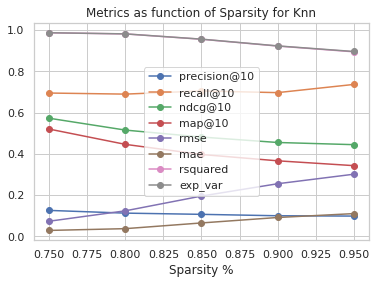

In [28]:
sns.set(style='whitegrid')
plt.plot(spt,r_pres,label="precision@10", marker = "o")
plt.plot(spt,r_recl,label="recall@10", marker = "o")
plt.plot(spt,r_ndcg,label="ndcg@10", marker = "o")
plt.plot(spt,r_maps,label="map@10", marker = "o")
plt.plot(spt,r_rmse,label="rmse", marker = "o")
plt.plot(spt,r_mae,label="mae", marker = "o")
plt.plot(spt,r_rsquared,label="rsquared", marker = "o")
plt.plot(spt,r_expvar,label="exp_var", marker = "o")


plt.title("Metrics as function of Sparsity for Knn")
plt.xlabel("Sparsity %")
plt.legend()
plt.savefig("metrics_over_sparsity_knn.png")

plt.show()

In [29]:
with open("knn_iterations.json", "w") as op:
    json.dump(results, op)

In [30]:
with open("knn_final_avg.json", "w") as op:
  json.dump(res, op)